### PARTE NO  ENTRENADA 

1/1 [==============================] - 0s 120ms/step


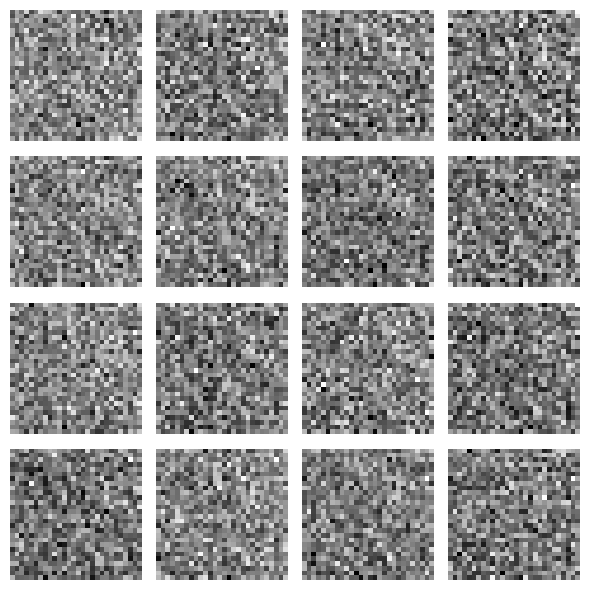

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam

class GANBuilder:
    def __init__(self, generator_input_dim=100, discriminator_input_shape=(28, 28, 1)):
        self.generator_input_dim = generator_input_dim
        self.discriminator_input_shape = discriminator_input_shape

    def _create_dense_block(self, units, alpha=0.2, momentum=0.8):
        return [
            Dense(units),
            LeakyReLU(alpha=alpha),
            BatchNormalization(momentum=momentum)
        ]

    def build_generator(self):
        model = Sequential(self._create_dense_block(256) +
                           self._create_dense_block(512) +
                           self._create_dense_block(1024) +
                           [Dense(784, activation='tanh'), Reshape(self.discriminator_input_shape)])
        model.build(input_shape=(None, self.generator_input_dim))
        return model
    
    def build_discriminator(self):
        model = Sequential([Flatten(input_shape=self.discriminator_input_shape)] +
                           self._create_dense_block(1024) +
                           self._create_dense_block(512) +
                           self._create_dense_block(256) +
                           [Dense(1, activation='sigmoid')])
        model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
        return model

    def build_gan(self, generator, discriminator):
        discriminator.trainable = False
        gan_input = Input(shape=(self.generator_input_dim,))
        gan_output = discriminator(generator(gan_input))
        gan = Model(gan_input, gan_output)
        gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
        return gan


def plot_images(generator, examples=16, dim=(4, 4), figsize=(6, 6)):
    noise = np.random.normal(0, 1, size=[examples, 100])
    generated_images = generator.predict(noise).reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
builder = GANBuilder()
generator = builder.build_generator()
discriminator = builder.build_discriminator()
gan = builder.build_gan(generator, discriminator)

plot_images(generator)


1/1 [==============================] - 0s 35ms/step
0 [D loss: 0.8963358998298645 | D accuracy: 62.5] [G loss: 0.8851180076599121]
1/1 [==============================] - 0s 36ms/step


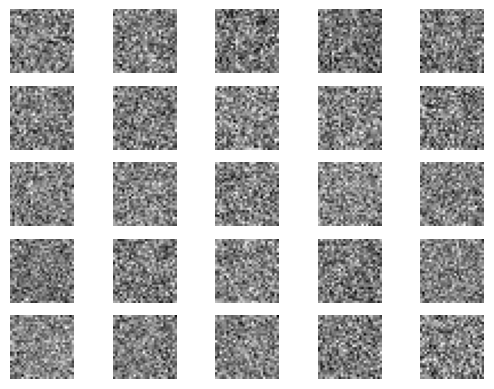

1/1 [==============================] - 0s 35ms/step
1 [D loss: 0.8505097031593323 | D accuracy: 53.125] [G loss: 0.9962101578712463]
1/1 [==============================] - 0s 32ms/step
2 [D loss: 0.8869548439979553 | D accuracy: 43.75] [G loss: 1.03152334690094]
1/1 [==============================] - 0s 33ms/step
3 [D loss: 0.8263324499130249 | D accuracy: 50.0] [G loss: 1.1046106815338135]
1/1 [==============================] - 0s 33ms/step
4 [D loss: 0.8304293155670166 | D accuracy: 53.125] [G loss: 1.1988415718078613]
1/1 [==============================] - 0s 43ms/step
5 [D loss: 0.8175612390041351 | D accuracy: 50.0] [G loss: 1.3792035579681396]
1/1 [==============================] - 0s 79ms/step
6 [D loss: 0.778703361749649 | D accuracy: 50.0] [G loss: 1.3502464294433594]
1/1 [==============================] - 0s 51ms/step
7 [D loss: 0.78153195977211 | D accuracy: 59.375] [G loss: 1.2608084678649902]
1/1 [==============================] - 0s 32ms/step
8 [D loss: 0.7874466478824615

1/1 [==============================] - 0s 34ms/step
63 [D loss: 0.7649313509464264 | D accuracy: 56.25] [G loss: 0.3054766058921814]
1/1 [==============================] - 0s 36ms/step
64 [D loss: 0.7821885049343109 | D accuracy: 56.25] [G loss: 0.3886184096336365]
1/1 [==============================] - 0s 35ms/step
65 [D loss: 0.7636372148990631 | D accuracy: 53.125] [G loss: 0.45961877703666687]
1/1 [==============================] - 0s 35ms/step
66 [D loss: 0.7570502161979675 | D accuracy: 53.125] [G loss: 0.4191441535949707]
1/1 [==============================] - 0s 35ms/step
67 [D loss: 0.7404144704341888 | D accuracy: 40.625] [G loss: 0.37823253870010376]
1/1 [==============================] - 0s 35ms/step
68 [D loss: 0.7381650805473328 | D accuracy: 56.25] [G loss: 0.37155479192733765]
1/1 [==============================] - 0s 37ms/step
69 [D loss: 0.7354546189308167 | D accuracy: 50.0] [G loss: 0.3454055190086365]
1/1 [==============================] - 0s 33ms/step
70 [D loss: 

1/1 [==============================] - 0s 36ms/step
124 [D loss: 0.724926233291626 | D accuracy: 59.375] [G loss: 0.315735399723053]
1/1 [==============================] - 0s 36ms/step
125 [D loss: 0.7347896695137024 | D accuracy: 43.75] [G loss: 0.2631112337112427]
1/1 [==============================] - 0s 33ms/step
126 [D loss: 0.7249486744403839 | D accuracy: 43.75] [G loss: 0.19910761713981628]
1/1 [==============================] - 0s 37ms/step
127 [D loss: 0.7173943519592285 | D accuracy: 46.875] [G loss: 0.23479579389095306]
1/1 [==============================] - 0s 36ms/step
128 [D loss: 0.7401026487350464 | D accuracy: 46.875] [G loss: 0.2509158253669739]
1/1 [==============================] - 0s 34ms/step
129 [D loss: 0.7275377810001373 | D accuracy: 50.0] [G loss: 0.28958460688591003]
1/1 [==============================] - 0s 34ms/step
130 [D loss: 0.7262671887874603 | D accuracy: 46.875] [G loss: 0.2075810432434082]
1/1 [==============================] - 0s 34ms/step
131 [D

1/1 [==============================] - 0s 42ms/step
185 [D loss: 0.7340832352638245 | D accuracy: 46.875] [G loss: 0.16821418702602386]
1/1 [==============================] - 0s 34ms/step
186 [D loss: 0.7232159376144409 | D accuracy: 50.0] [G loss: 0.18066146969795227]
1/1 [==============================] - 0s 33ms/step
187 [D loss: 0.7283722758293152 | D accuracy: 50.0] [G loss: 0.16736440360546112]
1/1 [==============================] - 0s 33ms/step
188 [D loss: 0.7464030385017395 | D accuracy: 43.75] [G loss: 0.22445514798164368]
1/1 [==============================] - 0s 35ms/step
189 [D loss: 0.7239078879356384 | D accuracy: 43.75] [G loss: 0.23593257367610931]
1/1 [==============================] - 0s 35ms/step
190 [D loss: 0.7246854901313782 | D accuracy: 50.0] [G loss: 0.21443723142147064]
1/1 [==============================] - 0s 35ms/step
191 [D loss: 0.71773761510849 | D accuracy: 53.125] [G loss: 0.22526831924915314]
1/1 [==============================] - 0s 34ms/step
192 [D

1/1 [==============================] - 0s 34ms/step
246 [D loss: 0.7175185680389404 | D accuracy: 40.625] [G loss: 0.15493673086166382]
1/1 [==============================] - 0s 34ms/step
247 [D loss: 0.726596474647522 | D accuracy: 43.75] [G loss: 0.20028159022331238]
1/1 [==============================] - 0s 34ms/step
248 [D loss: 0.7290269434452057 | D accuracy: 50.0] [G loss: 0.19992808997631073]
1/1 [==============================] - 0s 35ms/step
249 [D loss: 0.7151475846767426 | D accuracy: 53.125] [G loss: 0.17270931601524353]
1/1 [==============================] - 0s 39ms/step
250 [D loss: 0.7260249257087708 | D accuracy: 53.125] [G loss: 0.16840727627277374]
1/1 [==============================] - 0s 34ms/step
251 [D loss: 0.7273921072483063 | D accuracy: 59.375] [G loss: 0.1694493591785431]
1/1 [==============================] - 0s 38ms/step
252 [D loss: 0.7281158864498138 | D accuracy: 46.875] [G loss: 0.18767432868480682]
1/1 [==============================] - 0s 37ms/step
2

1/1 [==============================] - 0s 34ms/step
307 [D loss: 0.727341890335083 | D accuracy: 53.125] [G loss: 0.1641617715358734]
1/1 [==============================] - 0s 34ms/step
308 [D loss: 0.7248332500457764 | D accuracy: 46.875] [G loss: 0.1905139982700348]
1/1 [==============================] - 0s 33ms/step
309 [D loss: 0.7146341800689697 | D accuracy: 53.125] [G loss: 0.15865759551525116]
1/1 [==============================] - 0s 34ms/step
310 [D loss: 0.7112252712249756 | D accuracy: 43.75] [G loss: 0.21711760759353638]
1/1 [==============================] - 0s 33ms/step
311 [D loss: 0.7123355269432068 | D accuracy: 50.0] [G loss: 0.2152438908815384]
1/1 [==============================] - 0s 33ms/step
312 [D loss: 0.711540013551712 | D accuracy: 56.25] [G loss: 0.2018263339996338]
1/1 [==============================] - 0s 33ms/step
313 [D loss: 0.7164278626441956 | D accuracy: 50.0] [G loss: 0.22352513670921326]
1/1 [==============================] - 0s 34ms/step
314 [D l

1/1 [==============================] - 0s 36ms/step
368 [D loss: 0.708186686038971 | D accuracy: 53.125] [G loss: 0.18096362054347992]
1/1 [==============================] - 0s 34ms/step
369 [D loss: 0.7169105410575867 | D accuracy: 46.875] [G loss: 0.17995230853557587]
1/1 [==============================] - 0s 34ms/step
370 [D loss: 0.7124512195587158 | D accuracy: 43.75] [G loss: 0.15413103997707367]
1/1 [==============================] - 0s 34ms/step
371 [D loss: 0.7109421491622925 | D accuracy: 50.0] [G loss: 0.1704772710800171]
1/1 [==============================] - 0s 36ms/step
372 [D loss: 0.7112873792648315 | D accuracy: 46.875] [G loss: 0.16600634157657623]
1/1 [==============================] - 0s 33ms/step
373 [D loss: 0.7158973813056946 | D accuracy: 46.875] [G loss: 0.15735028684139252]
1/1 [==============================] - 0s 34ms/step
374 [D loss: 0.7231170237064362 | D accuracy: 46.875] [G loss: 0.2035801112651825]
1/1 [==============================] - 0s 35ms/step
37

1/1 [==============================] - 0s 34ms/step
429 [D loss: 0.7144996523857117 | D accuracy: 50.0] [G loss: 0.18572017550468445]
1/1 [==============================] - 0s 37ms/step
430 [D loss: 0.7135003805160522 | D accuracy: 46.875] [G loss: 0.19995805621147156]
1/1 [==============================] - 0s 33ms/step
431 [D loss: 0.7241954505443573 | D accuracy: 65.625] [G loss: 0.20678946375846863]
1/1 [==============================] - 0s 33ms/step
432 [D loss: 0.7101551592350006 | D accuracy: 53.125] [G loss: 0.18284930288791656]
1/1 [==============================] - 0s 32ms/step
433 [D loss: 0.7132972478866577 | D accuracy: 53.125] [G loss: 0.161763995885849]
1/1 [==============================] - 0s 75ms/step
434 [D loss: 0.7184799313545227 | D accuracy: 40.625] [G loss: 0.1604919731616974]
1/1 [==============================] - 0s 34ms/step
435 [D loss: 0.7148903012275696 | D accuracy: 56.25] [G loss: 0.16794724762439728]
1/1 [==============================] - 0s 37ms/step
43

1/1 [==============================] - 0s 33ms/step
490 [D loss: 0.7179762721061707 | D accuracy: 56.25] [G loss: 0.21375375986099243]
1/1 [==============================] - 0s 35ms/step
491 [D loss: 0.7059707641601562 | D accuracy: 50.0] [G loss: 0.2017560601234436]
1/1 [==============================] - 0s 34ms/step
492 [D loss: 0.7136184573173523 | D accuracy: 53.125] [G loss: 0.2063031792640686]
1/1 [==============================] - 0s 44ms/step
493 [D loss: 0.7128632664680481 | D accuracy: 50.0] [G loss: 0.23121032118797302]
1/1 [==============================] - 0s 33ms/step
494 [D loss: 0.7150101363658905 | D accuracy: 43.75] [G loss: 0.2336222231388092]
1/1 [==============================] - 0s 33ms/step
495 [D loss: 0.7236200571060181 | D accuracy: 59.375] [G loss: 0.2169739454984665]
1/1 [==============================] - 0s 34ms/step
496 [D loss: 0.7155015468597412 | D accuracy: 46.875] [G loss: 0.21875597536563873]
1/1 [==============================] - 0s 34ms/step
497 [D

1/1 [==============================] - 0s 35ms/step
551 [D loss: 0.7056590020656586 | D accuracy: 53.125] [G loss: 0.21888495981693268]
1/1 [==============================] - 0s 38ms/step
552 [D loss: 0.7135725021362305 | D accuracy: 50.0] [G loss: 0.1948116272687912]
1/1 [==============================] - 0s 41ms/step
553 [D loss: 0.7064436972141266 | D accuracy: 53.125] [G loss: 0.19165171682834625]
1/1 [==============================] - 0s 33ms/step
554 [D loss: 0.7078014016151428 | D accuracy: 50.0] [G loss: 0.19567586481571198]
1/1 [==============================] - 0s 50ms/step
555 [D loss: 0.7118610441684723 | D accuracy: 50.0] [G loss: 0.1734624207019806]
1/1 [==============================] - 0s 33ms/step
556 [D loss: 0.7003848254680634 | D accuracy: 59.375] [G loss: 0.2009490728378296]
1/1 [==============================] - 0s 39ms/step
557 [D loss: 0.7078579962253571 | D accuracy: 53.125] [G loss: 0.20632915198802948]
1/1 [==============================] - 0s 34ms/step
558 [

1/1 [==============================] - 0s 36ms/step
612 [D loss: 0.7125818133354187 | D accuracy: 50.0] [G loss: 0.18642494082450867]
1/1 [==============================] - 0s 34ms/step
613 [D loss: 0.7062104344367981 | D accuracy: 50.0] [G loss: 0.2028513252735138]
1/1 [==============================] - 0s 33ms/step
614 [D loss: 0.7001243233680725 | D accuracy: 46.875] [G loss: 0.19912806153297424]
1/1 [==============================] - 0s 33ms/step
615 [D loss: 0.7080808281898499 | D accuracy: 50.0] [G loss: 0.18065829575061798]
1/1 [==============================] - 0s 33ms/step
616 [D loss: 0.6987109184265137 | D accuracy: 53.125] [G loss: 0.1914260983467102]
1/1 [==============================] - 0s 33ms/step
617 [D loss: 0.7032068371772766 | D accuracy: 50.0] [G loss: 0.19876384735107422]
1/1 [==============================] - 0s 33ms/step
618 [D loss: 0.705453634262085 | D accuracy: 53.125] [G loss: 0.20854917168617249]
1/1 [==============================] - 0s 36ms/step
619 [D 

1/1 [==============================] - 0s 49ms/step
673 [D loss: 0.708571046590805 | D accuracy: 50.0] [G loss: 0.20796161890029907]
1/1 [==============================] - 0s 33ms/step
674 [D loss: 0.7014821171760559 | D accuracy: 53.125] [G loss: 0.19754816591739655]
1/1 [==============================] - 0s 33ms/step
675 [D loss: 0.7028107643127441 | D accuracy: 43.75] [G loss: 0.20182958245277405]
1/1 [==============================] - 0s 38ms/step
676 [D loss: 0.704444408416748 | D accuracy: 53.125] [G loss: 0.22509559988975525]
1/1 [==============================] - 0s 34ms/step
677 [D loss: 0.70497927069664 | D accuracy: 46.875] [G loss: 0.19996508955955505]
1/1 [==============================] - 0s 33ms/step
678 [D loss: 0.7037169933319092 | D accuracy: 50.0] [G loss: 0.22257855534553528]
1/1 [==============================] - 0s 32ms/step
679 [D loss: 0.7087107598781586 | D accuracy: 53.125] [G loss: 0.20710721611976624]
1/1 [==============================] - 0s 34ms/step
680 [

1/1 [==============================] - 0s 33ms/step
734 [D loss: 0.7037834525108337 | D accuracy: 50.0] [G loss: 0.2187146246433258]
1/1 [==============================] - 0s 32ms/step
735 [D loss: 0.7039823830127716 | D accuracy: 50.0] [G loss: 0.21804504096508026]
1/1 [==============================] - 0s 35ms/step
736 [D loss: 0.708047479391098 | D accuracy: 43.75] [G loss: 0.22372347116470337]
1/1 [==============================] - 0s 36ms/step
737 [D loss: 0.7031368017196655 | D accuracy: 40.625] [G loss: 0.22013893723487854]
1/1 [==============================] - 0s 34ms/step
738 [D loss: 0.6995221674442291 | D accuracy: 46.875] [G loss: 0.21532675623893738]
1/1 [==============================] - 0s 33ms/step
739 [D loss: 0.7003369927406311 | D accuracy: 50.0] [G loss: 0.21541589498519897]
1/1 [==============================] - 0s 50ms/step
740 [D loss: 0.7012758851051331 | D accuracy: 59.375] [G loss: 0.22210641205310822]
1/1 [==============================] - 0s 45ms/step
741 [

1/1 [==============================] - 0s 34ms/step
795 [D loss: 0.7078266441822052 | D accuracy: 53.125] [G loss: 0.21393214166164398]
1/1 [==============================] - 0s 34ms/step
796 [D loss: 0.7057951390743256 | D accuracy: 46.875] [G loss: 0.19685211777687073]
1/1 [==============================] - 0s 33ms/step
797 [D loss: 0.7066472172737122 | D accuracy: 43.75] [G loss: 0.2024838626384735]
1/1 [==============================] - 0s 35ms/step
798 [D loss: 0.7083087265491486 | D accuracy: 50.0] [G loss: 0.21705326437950134]
1/1 [==============================] - 0s 32ms/step
799 [D loss: 0.7024046182632446 | D accuracy: 53.125] [G loss: 0.20627379417419434]
1/1 [==============================] - 0s 33ms/step
800 [D loss: 0.7132410109043121 | D accuracy: 46.875] [G loss: 0.19379177689552307]
1/1 [==============================] - 0s 35ms/step
801 [D loss: 0.7079046666622162 | D accuracy: 53.125] [G loss: 0.21259978413581848]
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step
856 [D loss: 0.6999209821224213 | D accuracy: 53.125] [G loss: 0.21052920818328857]
1/1 [==============================] - 0s 35ms/step
857 [D loss: 0.7015726566314697 | D accuracy: 46.875] [G loss: 0.21833719313144684]
1/1 [==============================] - 0s 38ms/step
858 [D loss: 0.7026549875736237 | D accuracy: 46.875] [G loss: 0.22750520706176758]
1/1 [==============================] - 0s 34ms/step
859 [D loss: 0.6993871033191681 | D accuracy: 53.125] [G loss: 0.1924857199192047]
1/1 [==============================] - 0s 33ms/step
860 [D loss: 0.7037159204483032 | D accuracy: 56.25] [G loss: 0.230886310338974]
1/1 [==============================] - 0s 34ms/step
861 [D loss: 0.701107919216156 | D accuracy: 46.875] [G loss: 0.2067747712135315]
1/1 [==============================] - 0s 64ms/step
862 [D loss: 0.7030655741691589 | D accuracy: 46.875] [G loss: 0.2200106978416443]
1/1 [==============================] - 0s 34ms/step
863

1/1 [==============================] - 0s 34ms/step
917 [D loss: 0.7019401490688324 | D accuracy: 40.625] [G loss: 0.224900484085083]
1/1 [==============================] - 0s 38ms/step
918 [D loss: 0.7056792676448822 | D accuracy: 56.25] [G loss: 0.23284225165843964]
1/1 [==============================] - 0s 34ms/step
919 [D loss: 0.6987797915935516 | D accuracy: 53.125] [G loss: 0.23398105800151825]
1/1 [==============================] - 0s 36ms/step
920 [D loss: 0.7042735815048218 | D accuracy: 50.0] [G loss: 0.22955727577209473]
1/1 [==============================] - 0s 37ms/step
921 [D loss: 0.7017641067504883 | D accuracy: 50.0] [G loss: 0.2044263482093811]
1/1 [==============================] - 0s 41ms/step
922 [D loss: 0.7025890648365021 | D accuracy: 40.625] [G loss: 0.203841894865036]
1/1 [==============================] - 0s 36ms/step
923 [D loss: 0.6992869973182678 | D accuracy: 50.0] [G loss: 0.20860493183135986]
1/1 [==============================] - 0s 35ms/step
924 [D l

1/1 [==============================] - 0s 35ms/step
978 [D loss: 0.7021751999855042 | D accuracy: 53.125] [G loss: 0.21457605063915253]
1/1 [==============================] - 0s 34ms/step
979 [D loss: 0.6992825269699097 | D accuracy: 46.875] [G loss: 0.218098446726799]
1/1 [==============================] - 0s 34ms/step
980 [D loss: 0.699446439743042 | D accuracy: 46.875] [G loss: 0.23552840948104858]
1/1 [==============================] - 0s 34ms/step
981 [D loss: 0.6989006400108337 | D accuracy: 53.125] [G loss: 0.20803800225257874]
1/1 [==============================] - 0s 34ms/step
982 [D loss: 0.7003728449344635 | D accuracy: 50.0] [G loss: 0.2144967019557953]
1/1 [==============================] - 0s 38ms/step
983 [D loss: 0.6990134119987488 | D accuracy: 37.5] [G loss: 0.22128023207187653]
1/1 [==============================] - 0s 35ms/step
984 [D loss: 0.7011812329292297 | D accuracy: 50.0] [G loss: 0.2227657288312912]
1/1 [==============================] - 0s 34ms/step
985 [D 

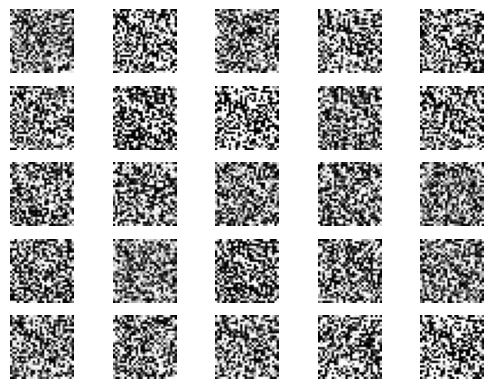

1/1 [==============================] - 0s 37ms/step
1001 [D loss: 0.6983285546302795 | D accuracy: 59.375] [G loss: 0.22181767225265503]
1/1 [==============================] - 0s 43ms/step
1002 [D loss: 0.7008890509605408 | D accuracy: 56.25] [G loss: 0.1984364539384842]
1/1 [==============================] - 0s 40ms/step
1003 [D loss: 0.7016220390796661 | D accuracy: 46.875] [G loss: 0.2030162811279297]
1/1 [==============================] - 0s 35ms/step
1004 [D loss: 0.7002931237220764 | D accuracy: 50.0] [G loss: 0.18805328011512756]
1/1 [==============================] - 0s 36ms/step
1005 [D loss: 0.6970606446266174 | D accuracy: 56.25] [G loss: 0.1887630820274353]
1/1 [==============================] - 0s 35ms/step
1006 [D loss: 0.6985895037651062 | D accuracy: 40.625] [G loss: 0.18666669726371765]
1/1 [==============================] - 0s 35ms/step
1007 [D loss: 0.6978914439678192 | D accuracy: 50.0] [G loss: 0.21023324131965637]
1/1 [==============================] - 0s 35ms/ste

1/1 [==============================] - 0s 34ms/step
1062 [D loss: 0.6998952627182007 | D accuracy: 56.25] [G loss: 0.19718720018863678]
1/1 [==============================] - 0s 34ms/step
1063 [D loss: 0.7017898261547089 | D accuracy: 43.75] [G loss: 0.2124004364013672]
1/1 [==============================] - 0s 41ms/step
1064 [D loss: 0.7018434107303619 | D accuracy: 46.875] [G loss: 0.20657199621200562]
1/1 [==============================] - 0s 35ms/step
1065 [D loss: 0.6990257203578949 | D accuracy: 50.0] [G loss: 0.2081449329853058]
1/1 [==============================] - 0s 35ms/step
1066 [D loss: 0.7034646272659302 | D accuracy: 50.0] [G loss: 0.20706501603126526]
1/1 [==============================] - 0s 34ms/step
1067 [D loss: 0.7031987905502319 | D accuracy: 53.125] [G loss: 0.2356233298778534]
1/1 [==============================] - 0s 35ms/step
1068 [D loss: 0.7039190232753754 | D accuracy: 46.875] [G loss: 0.24395309388637543]
1/1 [==============================] - 0s 35ms/ste

1/1 [==============================] - 0s 35ms/step
1122 [D loss: 0.6999157965183258 | D accuracy: 46.875] [G loss: 0.23788781464099884]
1/1 [==============================] - 0s 34ms/step
1123 [D loss: 0.6994748711585999 | D accuracy: 53.125] [G loss: 0.21747954189777374]
1/1 [==============================] - 0s 41ms/step
1124 [D loss: 0.7012025117874146 | D accuracy: 50.0] [G loss: 0.21800881624221802]
1/1 [==============================] - 0s 36ms/step
1125 [D loss: 0.7042425572872162 | D accuracy: 46.875] [G loss: 0.22720277309417725]
1/1 [==============================] - 0s 35ms/step
1126 [D loss: 0.699063241481781 | D accuracy: 46.875] [G loss: 0.22218291461467743]
1/1 [==============================] - 0s 34ms/step
1127 [D loss: 0.7006023526191711 | D accuracy: 50.0] [G loss: 0.2344937026500702]
1/1 [==============================] - 0s 33ms/step
1128 [D loss: 0.7011713087558746 | D accuracy: 50.0] [G loss: 0.2401306927204132]
1/1 [==============================] - 0s 34ms/ste

1182 [D loss: 0.7009039521217346 | D accuracy: 43.75] [G loss: 0.2216731607913971]
1/1 [==============================] - 0s 34ms/step
1183 [D loss: 0.6977016925811768 | D accuracy: 59.375] [G loss: 0.2347467690706253]
1/1 [==============================] - 0s 40ms/step
1184 [D loss: 0.6980505585670471 | D accuracy: 53.125] [G loss: 0.24734605848789215]
1/1 [==============================] - 0s 35ms/step
1185 [D loss: 0.6998156607151031 | D accuracy: 50.0] [G loss: 0.24412128329277039]
1/1 [==============================] - 0s 35ms/step
1186 [D loss: 0.6979433000087738 | D accuracy: 46.875] [G loss: 0.24509498476982117]
1/1 [==============================] - 0s 35ms/step
1187 [D loss: 0.6975328624248505 | D accuracy: 46.875] [G loss: 0.24113920331001282]
1/1 [==============================] - 0s 34ms/step
1188 [D loss: 0.6993902623653412 | D accuracy: 50.0] [G loss: 0.2345218062400818]
1/1 [==============================] - 0s 35ms/step
1189 [D loss: 0.6997312307357788 | D accuracy: 46

1/1 [==============================] - 0s 39ms/step
1243 [D loss: 0.6992971003055573 | D accuracy: 59.375] [G loss: 0.21673299372196198]
1/1 [==============================] - 0s 36ms/step
1244 [D loss: 0.6995372474193573 | D accuracy: 50.0] [G loss: 0.24169650673866272]
1/1 [==============================] - 0s 35ms/step
1245 [D loss: 0.6979533433914185 | D accuracy: 46.875] [G loss: 0.24633072316646576]
1/1 [==============================] - 0s 35ms/step
1246 [D loss: 0.6979482173919678 | D accuracy: 53.125] [G loss: 0.23221300542354584]
1/1 [==============================] - 0s 35ms/step
1247 [D loss: 0.7013813853263855 | D accuracy: 46.875] [G loss: 0.2147367298603058]
1/1 [==============================] - 0s 33ms/step
1248 [D loss: 0.6961434185504913 | D accuracy: 46.875] [G loss: 0.2551470398902893]
1/1 [==============================] - 0s 35ms/step
1249 [D loss: 0.6971180140972137 | D accuracy: 43.75] [G loss: 0.23585015535354614]
1/1 [==============================] - 0s 34ms

1/1 [==============================] - 0s 54ms/step
1303 [D loss: 0.7066128253936768 | D accuracy: 53.125] [G loss: 0.23234158754348755]
1/1 [==============================] - 0s 34ms/step
1304 [D loss: 0.7043493986129761 | D accuracy: 46.875] [G loss: 0.24961991608142853]
1/1 [==============================] - 0s 36ms/step
1305 [D loss: 0.6976319253444672 | D accuracy: 56.25] [G loss: 0.2535759210586548]
1/1 [==============================] - 0s 34ms/step
1306 [D loss: 0.6989370882511139 | D accuracy: 50.0] [G loss: 0.2122848927974701]
1/1 [==============================] - 0s 38ms/step
1307 [D loss: 0.6971094906330109 | D accuracy: 59.375] [G loss: 0.2269076555967331]
1/1 [==============================] - 0s 35ms/step
1308 [D loss: 0.6957228481769562 | D accuracy: 56.25] [G loss: 0.2349034547805786]
1/1 [==============================] - 0s 36ms/step
1309 [D loss: 0.698187530040741 | D accuracy: 56.25] [G loss: 0.23294705152511597]
1/1 [==============================] - 0s 37ms/step

1363 [D loss: 0.6985237300395966 | D accuracy: 46.875] [G loss: 0.258829802274704]
1/1 [==============================] - 0s 36ms/step
1364 [D loss: 0.6986818313598633 | D accuracy: 43.75] [G loss: 0.24472789466381073]
1/1 [==============================] - 0s 38ms/step
1365 [D loss: 0.6996788382530212 | D accuracy: 50.0] [G loss: 0.2409047931432724]
1/1 [==============================] - 0s 36ms/step
1366 [D loss: 0.6973023116588593 | D accuracy: 53.125] [G loss: 0.2390373945236206]
1/1 [==============================] - 0s 36ms/step
1367 [D loss: 0.6998171210289001 | D accuracy: 53.125] [G loss: 0.2464052438735962]
1/1 [==============================] - 0s 37ms/step
1368 [D loss: 0.6982874870300293 | D accuracy: 56.25] [G loss: 0.238856703042984]
1/1 [==============================] - 0s 38ms/step
1369 [D loss: 0.6976447105407715 | D accuracy: 46.875] [G loss: 0.23956196010112762]
1/1 [==============================] - 0s 35ms/step
1370 [D loss: 0.6998364627361298 | D accuracy: 50.0]

1/1 [==============================] - 0s 36ms/step
1424 [D loss: 0.6954690217971802 | D accuracy: 43.75] [G loss: 0.25441843271255493]
1/1 [==============================] - 0s 36ms/step
1425 [D loss: 0.6964702904224396 | D accuracy: 59.375] [G loss: 0.2543514370918274]
1/1 [==============================] - 0s 49ms/step
1426 [D loss: 0.6985568702220917 | D accuracy: 50.0] [G loss: 0.24771887063980103]
1/1 [==============================] - 0s 35ms/step
1427 [D loss: 0.6992913484573364 | D accuracy: 59.375] [G loss: 0.26047736406326294]
1/1 [==============================] - 0s 35ms/step
1428 [D loss: 0.6988421976566315 | D accuracy: 53.125] [G loss: 0.24465206265449524]
1/1 [==============================] - 0s 34ms/step
1429 [D loss: 0.6968700289726257 | D accuracy: 43.75] [G loss: 0.24696128070354462]
1/1 [==============================] - 0s 35ms/step
1430 [D loss: 0.6973408460617065 | D accuracy: 50.0] [G loss: 0.26900696754455566]
1/1 [==============================] - 0s 34ms/s

1/1 [==============================] - 0s 35ms/step
1484 [D loss: 0.6974538564682007 | D accuracy: 50.0] [G loss: 0.2611454129219055]
1/1 [==============================] - 0s 36ms/step
1485 [D loss: 0.6987835168838501 | D accuracy: 50.0] [G loss: 0.2606233060359955]
1/1 [==============================] - 0s 37ms/step
1486 [D loss: 0.6978118717670441 | D accuracy: 43.75] [G loss: 0.2621231973171234]
1/1 [==============================] - 0s 38ms/step
1487 [D loss: 0.6982559859752655 | D accuracy: 50.0] [G loss: 0.2445172220468521]
1/1 [==============================] - 0s 39ms/step
1488 [D loss: 0.6983579993247986 | D accuracy: 50.0] [G loss: 0.24110233783721924]
1/1 [==============================] - 0s 41ms/step
1489 [D loss: 0.6986649334430695 | D accuracy: 62.5] [G loss: 0.25305721163749695]
1/1 [==============================] - 0s 38ms/step
1490 [D loss: 0.6968282163143158 | D accuracy: 46.875] [G loss: 0.26535242795944214]
1/1 [==============================] - 0s 36ms/step
1491

1/1 [==============================] - 0s 35ms/step
1545 [D loss: 0.6948903799057007 | D accuracy: 40.625] [G loss: 0.2660668194293976]
1/1 [==============================] - 0s 38ms/step
1546 [D loss: 0.6951853930950165 | D accuracy: 53.125] [G loss: 0.27944743633270264]
1/1 [==============================] - 0s 36ms/step
1547 [D loss: 0.6968816220760345 | D accuracy: 43.75] [G loss: 0.26220083236694336]
1/1 [==============================] - 0s 38ms/step
1548 [D loss: 0.6947434842586517 | D accuracy: 43.75] [G loss: 0.25211992859840393]
1/1 [==============================] - 0s 37ms/step
1549 [D loss: 0.696231484413147 | D accuracy: 46.875] [G loss: 0.2656201124191284]
1/1 [==============================] - 0s 37ms/step
1550 [D loss: 0.6976748704910278 | D accuracy: 46.875] [G loss: 0.27173393964767456]
1/1 [==============================] - 0s 37ms/step
1551 [D loss: 0.6984283328056335 | D accuracy: 53.125] [G loss: 0.2581965923309326]
1/1 [==============================] - 0s 37ms/

1/1 [==============================] - 0s 36ms/step
1606 [D loss: 0.6961678862571716 | D accuracy: 40.625] [G loss: 0.24887612462043762]
1/1 [==============================] - 0s 37ms/step
1607 [D loss: 0.6967623829841614 | D accuracy: 56.25] [G loss: 0.23812583088874817]
1/1 [==============================] - 0s 37ms/step
1608 [D loss: 0.697475790977478 | D accuracy: 50.0] [G loss: 0.23899725079536438]
1/1 [==============================] - 0s 35ms/step
1609 [D loss: 0.6969625353813171 | D accuracy: 50.0] [G loss: 0.24188704788684845]
1/1 [==============================] - 0s 38ms/step
1610 [D loss: 0.6950567662715912 | D accuracy: 50.0] [G loss: 0.26600900292396545]
1/1 [==============================] - 0s 38ms/step
1611 [D loss: 0.6953907310962677 | D accuracy: 43.75] [G loss: 0.2505049705505371]
1/1 [==============================] - 0s 37ms/step
1612 [D loss: 0.6964784562587738 | D accuracy: 53.125] [G loss: 0.2517366409301758]
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 38ms/step
1667 [D loss: 0.6987299621105194 | D accuracy: 50.0] [G loss: 0.2592489719390869]
1/1 [==============================] - 0s 39ms/step
1668 [D loss: 0.6972839534282684 | D accuracy: 50.0] [G loss: 0.274417519569397]
1/1 [==============================] - 0s 38ms/step
1669 [D loss: 0.6950494050979614 | D accuracy: 56.25] [G loss: 0.26911020278930664]
1/1 [==============================] - 0s 38ms/step
1670 [D loss: 0.6970958709716797 | D accuracy: 53.125] [G loss: 0.25876912474632263]
1/1 [==============================] - 0s 39ms/step
1671 [D loss: 0.6954881548881531 | D accuracy: 40.625] [G loss: 0.2584823966026306]
1/1 [==============================] - 0s 36ms/step
1672 [D loss: 0.695739209651947 | D accuracy: 46.875] [G loss: 0.25790655612945557]
1/1 [==============================] - 0s 43ms/step
1673 [D loss: 0.6968929469585419 | D accuracy: 50.0] [G loss: 0.2542077898979187]
1/1 [==============================] - 0s 38ms/step
16

1727 [D loss: 0.6983324587345123 | D accuracy: 43.75] [G loss: 0.26788395643234253]
1/1 [==============================] - 0s 53ms/step
1728 [D loss: 0.6972703337669373 | D accuracy: 40.625] [G loss: 0.25241196155548096]
1/1 [==============================] - 0s 44ms/step
1729 [D loss: 0.6960105895996094 | D accuracy: 53.125] [G loss: 0.26889342069625854]
1/1 [==============================] - 0s 52ms/step
1730 [D loss: 0.6959509551525116 | D accuracy: 50.0] [G loss: 0.26123276352882385]
1/1 [==============================] - 0s 56ms/step
1731 [D loss: 0.6964697241783142 | D accuracy: 50.0] [G loss: 0.28235575556755066]
1/1 [==============================] - 0s 46ms/step
1732 [D loss: 0.6955487430095673 | D accuracy: 56.25] [G loss: 0.2846711575984955]
1/1 [==============================] - 0s 43ms/step
1733 [D loss: 0.6950940787792206 | D accuracy: 46.875] [G loss: 0.26675254106521606]
1/1 [==============================] - 0s 68ms/step
1734 [D loss: 0.6957193911075592 | D accuracy: 5

1/1 [==============================] - 0s 36ms/step
1788 [D loss: 0.6957161724567413 | D accuracy: 37.5] [G loss: 0.25706931948661804]
1/1 [==============================] - 0s 39ms/step
1789 [D loss: 0.6953884959220886 | D accuracy: 59.375] [G loss: 0.26531776785850525]
1/1 [==============================] - 0s 36ms/step
1790 [D loss: 0.6950773596763611 | D accuracy: 46.875] [G loss: 0.25075316429138184]
1/1 [==============================] - 0s 36ms/step
1791 [D loss: 0.694915384054184 | D accuracy: 46.875] [G loss: 0.27446532249450684]
1/1 [==============================] - 0s 38ms/step
1792 [D loss: 0.6956494748592377 | D accuracy: 50.0] [G loss: 0.2696213126182556]
1/1 [==============================] - 0s 38ms/step
1793 [D loss: 0.6971598863601685 | D accuracy: 53.125] [G loss: 0.27512380480766296]
1/1 [==============================] - 0s 39ms/step
1794 [D loss: 0.6955163180828094 | D accuracy: 50.0] [G loss: 0.2648724317550659]
1/1 [==============================] - 0s 39ms/ste

1/1 [==============================] - 0s 39ms/step
1849 [D loss: 0.6954519748687744 | D accuracy: 50.0] [G loss: 0.2767114043235779]
1/1 [==============================] - 0s 38ms/step
1850 [D loss: 0.6976635456085205 | D accuracy: 40.625] [G loss: 0.2748908996582031]
1/1 [==============================] - 0s 37ms/step
1851 [D loss: 0.6952411532402039 | D accuracy: 43.75] [G loss: 0.2585987150669098]
1/1 [==============================] - 0s 38ms/step
1852 [D loss: 0.6961832046508789 | D accuracy: 50.0] [G loss: 0.24840417504310608]
1/1 [==============================] - 0s 38ms/step
1853 [D loss: 0.6955753862857819 | D accuracy: 46.875] [G loss: 0.2624521255493164]
1/1 [==============================] - 0s 38ms/step
1854 [D loss: 0.6956549882888794 | D accuracy: 56.25] [G loss: 0.2557220160961151]
1/1 [==============================] - 0s 35ms/step
1855 [D loss: 0.6965703964233398 | D accuracy: 53.125] [G loss: 0.2572423219680786]
1/1 [==============================] - 0s 39ms/step
1

1/1 [==============================] - 0s 47ms/step
1910 [D loss: 0.6958771646022797 | D accuracy: 46.875] [G loss: 0.26300787925720215]
1/1 [==============================] - 0s 39ms/step
1911 [D loss: 0.6947260499000549 | D accuracy: 53.125] [G loss: 0.28216731548309326]
1/1 [==============================] - 0s 40ms/step
1912 [D loss: 0.6955385804176331 | D accuracy: 46.875] [G loss: 0.2563166320323944]
1/1 [==============================] - 0s 40ms/step
1913 [D loss: 0.6969589591026306 | D accuracy: 50.0] [G loss: 0.26559603214263916]
1/1 [==============================] - 0s 39ms/step
1914 [D loss: 0.6958918869495392 | D accuracy: 50.0] [G loss: 0.2872309684753418]
1/1 [==============================] - 0s 39ms/step
1915 [D loss: 0.6963183283805847 | D accuracy: 46.875] [G loss: 0.25450873374938965]
1/1 [==============================] - 0s 39ms/step
1916 [D loss: 0.696829229593277 | D accuracy: 46.875] [G loss: 0.2652328908443451]
1/1 [==============================] - 0s 40ms/st

1/1 [==============================] - 0s 38ms/step
1971 [D loss: 0.6946889758110046 | D accuracy: 37.5] [G loss: 0.3062824606895447]
1/1 [==============================] - 0s 37ms/step
1972 [D loss: 0.6952420771121979 | D accuracy: 46.875] [G loss: 0.2855946719646454]
1/1 [==============================] - 0s 37ms/step
1973 [D loss: 0.6958284974098206 | D accuracy: 59.375] [G loss: 0.29187434911727905]
1/1 [==============================] - 0s 36ms/step
1974 [D loss: 0.6952182650566101 | D accuracy: 53.125] [G loss: 0.280356764793396]
1/1 [==============================] - 0s 36ms/step
1975 [D loss: 0.694932758808136 | D accuracy: 62.5] [G loss: 0.2824442982673645]
1/1 [==============================] - 0s 35ms/step
1976 [D loss: 0.6942999064922333 | D accuracy: 43.75] [G loss: 0.2951967716217041]
1/1 [==============================] - 0s 38ms/step
1977 [D loss: 0.6950344145298004 | D accuracy: 50.0] [G loss: 0.28785982728004456]
1/1 [==============================] - 0s 36ms/step
197

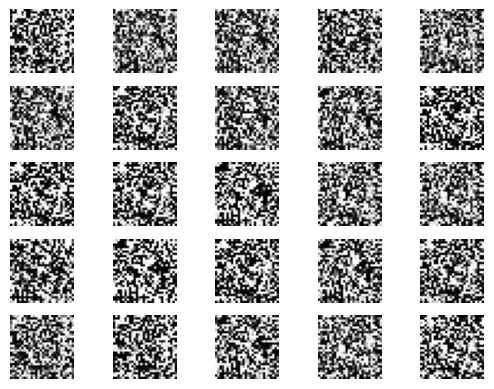

1/1 [==============================] - 0s 40ms/step
2001 [D loss: 0.6950393617153168 | D accuracy: 43.75] [G loss: 0.27637749910354614]
1/1 [==============================] - 0s 41ms/step
2002 [D loss: 0.6942544877529144 | D accuracy: 62.5] [G loss: 0.27239352464675903]
1/1 [==============================] - 0s 41ms/step
2003 [D loss: 0.6949363648891449 | D accuracy: 40.625] [G loss: 0.28458017110824585]
1/1 [==============================] - 0s 39ms/step
2004 [D loss: 0.6953958570957184 | D accuracy: 53.125] [G loss: 0.26171761751174927]
1/1 [==============================] - 0s 45ms/step
2005 [D loss: 0.6959909796714783 | D accuracy: 62.5] [G loss: 0.26388317346572876]
1/1 [==============================] - 0s 39ms/step
2006 [D loss: 0.6949865818023682 | D accuracy: 56.25] [G loss: 0.2578200101852417]
1/1 [==============================] - 0s 39ms/step
2007 [D loss: 0.6958020031452179 | D accuracy: 46.875] [G loss: 0.27683860063552856]
1/1 [==============================] - 0s 39ms/s

1/1 [==============================] - 0s 39ms/step
2062 [D loss: 0.6940439343452454 | D accuracy: 56.25] [G loss: 0.2956526577472687]
1/1 [==============================] - 0s 37ms/step
2063 [D loss: 0.6951818764209747 | D accuracy: 50.0] [G loss: 0.28962141275405884]
1/1 [==============================] - 0s 49ms/step
2064 [D loss: 0.6949309408664703 | D accuracy: 53.125] [G loss: 0.2885825037956238]
1/1 [==============================] - 0s 49ms/step
2065 [D loss: 0.694891095161438 | D accuracy: 50.0] [G loss: 0.27590417861938477]
1/1 [==============================] - 0s 45ms/step
2066 [D loss: 0.6949340999126434 | D accuracy: 50.0] [G loss: 0.292589008808136]
1/1 [==============================] - 0s 39ms/step
2067 [D loss: 0.6952624022960663 | D accuracy: 53.125] [G loss: 0.2882639467716217]
1/1 [==============================] - 0s 39ms/step
2068 [D loss: 0.6946015655994415 | D accuracy: 50.0] [G loss: 0.2820407748222351]
1/1 [==============================] - 0s 38ms/step
2069 

1/1 [==============================] - 0s 38ms/step
2123 [D loss: 0.694887638092041 | D accuracy: 50.0] [G loss: 0.2452065646648407]
1/1 [==============================] - 0s 39ms/step
2124 [D loss: 0.6948646306991577 | D accuracy: 59.375] [G loss: 0.26562583446502686]
1/1 [==============================] - 0s 42ms/step
2125 [D loss: 0.694651335477829 | D accuracy: 50.0] [G loss: 0.28297922015190125]
1/1 [==============================] - 0s 38ms/step
2126 [D loss: 0.6958304047584534 | D accuracy: 56.25] [G loss: 0.25895941257476807]
1/1 [==============================] - 0s 39ms/step
2127 [D loss: 0.6958993077278137 | D accuracy: 53.125] [G loss: 0.2492864429950714]
1/1 [==============================] - 0s 38ms/step
2128 [D loss: 0.6944652795791626 | D accuracy: 46.875] [G loss: 0.26275843381881714]
1/1 [==============================] - 0s 40ms/step
2129 [D loss: 0.6942247748374939 | D accuracy: 50.0] [G loss: 0.273196816444397]
1/1 [==============================] - 0s 38ms/step
21

1/1 [==============================] - 0s 42ms/step
2184 [D loss: 0.6946228742599487 | D accuracy: 50.0] [G loss: 0.3047294616699219]
1/1 [==============================] - 0s 49ms/step
2185 [D loss: 0.694553405046463 | D accuracy: 59.375] [G loss: 0.3139198422431946]
1/1 [==============================] - 0s 43ms/step
2186 [D loss: 0.6939706802368164 | D accuracy: 50.0] [G loss: 0.3020023703575134]
1/1 [==============================] - 0s 40ms/step
2187 [D loss: 0.6948132216930389 | D accuracy: 56.25] [G loss: 0.29831936955451965]
1/1 [==============================] - 0s 44ms/step
2188 [D loss: 0.6945698261260986 | D accuracy: 53.125] [G loss: 0.28402119874954224]
1/1 [==============================] - 0s 40ms/step
2189 [D loss: 0.6956419050693512 | D accuracy: 34.375] [G loss: 0.28491753339767456]
1/1 [==============================] - 0s 39ms/step
2190 [D loss: 0.6950325071811676 | D accuracy: 46.875] [G loss: 0.30270227789878845]
1/1 [==============================] - 0s 45ms/ste

1/1 [==============================] - 0s 37ms/step
2245 [D loss: 0.6950302422046661 | D accuracy: 56.25] [G loss: 0.32574060559272766]
1/1 [==============================] - 0s 40ms/step
2246 [D loss: 0.6948734521865845 | D accuracy: 50.0] [G loss: 0.32020312547683716]
1/1 [==============================] - 0s 41ms/step
2247 [D loss: 0.694688618183136 | D accuracy: 46.875] [G loss: 0.34011054039001465]
1/1 [==============================] - 0s 36ms/step
2248 [D loss: 0.6947357654571533 | D accuracy: 50.0] [G loss: 0.33204329013824463]
1/1 [==============================] - 0s 40ms/step
2249 [D loss: 0.6946876347064972 | D accuracy: 50.0] [G loss: 0.33304643630981445]
1/1 [==============================] - 0s 39ms/step
2250 [D loss: 0.694193959236145 | D accuracy: 46.875] [G loss: 0.317632257938385]
1/1 [==============================] - 0s 40ms/step
2251 [D loss: 0.6947536468505859 | D accuracy: 46.875] [G loss: 0.3281070590019226]
1/1 [==============================] - 0s 41ms/step
2

2305 [D loss: 0.6948848366737366 | D accuracy: 53.125] [G loss: 0.31946828961372375]
1/1 [==============================] - 0s 39ms/step
2306 [D loss: 0.6944611668586731 | D accuracy: 53.125] [G loss: 0.2939145565032959]
1/1 [==============================] - 0s 39ms/step
2307 [D loss: 0.6947145760059357 | D accuracy: 40.625] [G loss: 0.3010733723640442]
1/1 [==============================] - 0s 40ms/step
2308 [D loss: 0.6942973434925079 | D accuracy: 46.875] [G loss: 0.3021305203437805]
1/1 [==============================] - 0s 41ms/step
2309 [D loss: 0.6943901181221008 | D accuracy: 46.875] [G loss: 0.3279763460159302]
1/1 [==============================] - 0s 43ms/step
2310 [D loss: 0.6942806839942932 | D accuracy: 46.875] [G loss: 0.33195188641548157]
1/1 [==============================] - 0s 41ms/step
2311 [D loss: 0.6951698958873749 | D accuracy: 43.75] [G loss: 0.3241104483604431]
1/1 [==============================] - 0s 39ms/step
2312 [D loss: 0.6952122449874878 | D accuracy: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

class GANBuilder:
    def __init__(self, generator_input_dim=100, discriminator_input_shape=(28, 28, 1)):
        self.generator_input_dim = generator_input_dim
        self.discriminator_input_shape = discriminator_input_shape

    def _create_dense_block(self, units, alpha=0.2, momentum=0.8):
        return [
            Dense(units),
            LeakyReLU(alpha=alpha),
            BatchNormalization(momentum=momentum)
        ]

    def build_generator(self):
        model = Sequential(self._create_dense_block(256) +
                           self._create_dense_block(512) +
                           self._create_dense_block(1024) +
                           [Dense(np.prod(self.discriminator_input_shape), activation='tanh'), 
                            Reshape(self.discriminator_input_shape)])
        model.build(input_shape=(None, self.generator_input_dim))
        return model
    
    def build_discriminator(self):
        model = Sequential([Flatten(input_shape=self.discriminator_input_shape)] +
                           self._create_dense_block(512) +
                           self._create_dense_block(256) +
                           [Dense(1, activation='sigmoid')])
        model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
        return model

    def build_gan(self, generator, discriminator):
        discriminator.trainable = False
        gan_input = Input(shape=(self.generator_input_dim,))
        gan_output = discriminator(generator(gan_input))
        gan = Model(gan_input, gan_output)
        gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
        return gan

# Load MNIST data
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)

# Example usage:
builder = GANBuilder()
generator = builder.build_generator()
discriminator = builder.build_discriminator()
gan = builder.build_gan(generator, discriminator)

# Training parameters
epochs = 5000  # Increase this value for better results (e.g., 20000)
batch_size = 32
half_batch = batch_size // 2

# Training loop
for epoch in range(epochs):

    # Train discriminator
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    real_images = X_train[idx]
    noise = np.random.normal(0, 1, (half_batch, 100))
    generated_images = generator.predict(noise)
    
    real_y = np.ones((half_batch, 1))
    fake_y = np.zeros((half_batch, 1))

    d_loss_real = discriminator.train_on_batch(real_images, real_y)
    d_loss_fake = discriminator.train_on_batch(generated_images, fake_y)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_y = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_y)

    # Print the progress
    print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss}]")

    # If at save interval => save generated image samples
    if epoch % 1000 == 0:
        # Plot the progress
        noise = np.random.normal(0, 1, (25, 100))
        gen_imgs = generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(5, 5)
        cnt = 0
        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
